# Applying Data Science Model Development (XGboost)

## 1. Preprocess the data

In [18]:
pip install optuna

In [19]:
# === Step 0: Import Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
import optuna
import joblib
import warnings
warnings.filterwarnings('ignore')

In [20]:
# === Step 1: Data Preparation ===
# Load the data (train, validate, and test)
df = pd.read_csv("Final_v2_processed.csv") 
test_df = pd.read_csv("Final_test_v2_processed.csv")

# Convert 'addr_state' from string to numeric
le = LabelEncoder()
df["addr_state"] = le.fit_transform(df["addr_state"]) 
test_df["addr_state"] = le.fit_transform(test_df["addr_state"])

# Extract features and target
target_col = "loan_status"
feature_cols = [col for col in df.columns if col != target_col and col != "id"]

X = df[feature_cols].values
y = df[target_col].values
X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# No need to reshape for XGBoost because it works with 2D data: [n_samples, n_features]

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

## 2. Hyperparameter Tuning

In [21]:
# === Step 2: Optuna Hyperparameter Tuning ===
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
    }
    
    evals_result = {}
    model = xgb.train(
        param,
        dtrain,
        num_boost_round=100,
        evals=[(dval, 'validation')],
        early_stopping_rounds=10,
        evals_result=evals_result,
        verbose_eval=False
    )
    
    # Get best score
    preds = model.predict(dval)
    y_pred_binary = [1 if pred > 0.5 else 0 for pred in preds]
    f1 = f1_score(y_val, y_pred_binary, average="weighted")
    
    return 1 - f1  # Optuna minimizes, so we use 1 - F1

# Run Optuna
study = optuna.create_study()
study.optimize(objective, n_trials=20)
best_params = study.best_trial.params
print("Best hyperparameters:", best_params)

[I 2025-04-04 18:25:30,642] A new study created in memory with name: no-name-674b1294-3fae-4390-9217-f604de2bed38
[I 2025-04-04 18:25:31,189] Trial 0 finished with value: 0.24116101152885172 and parameters: {'booster': 'gbtree', 'max_depth': 10, 'learning_rate': 0.012814666482815276, 'n_estimators': 135, 'min_child_weight': 5, 'gamma': 0.1802088709866973, 'subsample': 0.9678617693387324, 'colsample_bytree': 0.9073503815957363, 'reg_alpha': 6.831627431293908e-05, 'reg_lambda': 0.006466562943463122}. Best is trial 0 with value: 0.24116101152885172.
[I 2025-04-04 18:25:32,329] Trial 1 finished with value: 0.24116101152885172 and parameters: {'booster': 'dart', 'max_depth': 7, 'learning_rate': 0.01363451752894322, 'n_estimators': 326, 'min_child_weight': 7, 'gamma': 9.456963176723112e-08, 'subsample': 0.7002876887196616, 'colsample_bytree': 0.6555797279168201, 'reg_alpha': 0.00012032009756542735, 'reg_lambda': 7.111798119673385e-07}. Best is trial 0 with value: 0.24116101152885172.
[I 2025

KeyboardInterrupt: 

## 3. Re-learn with the optimized parameters

In [ ]:
# === Step 3: Train Final Model with Best Params ===
# Extract parameters from best trial
final_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'booster': best_params['booster'],
    'max_depth': best_params['max_depth'],
    'learning_rate': best_params['learning_rate'],
    'min_child_weight': best_params['min_child_weight'],
    'gamma': best_params['gamma'],
    'subsample': best_params['subsample'],
    'colsample_bytree': best_params['colsample_bytree'],
    'reg_alpha': best_params['reg_alpha'],
    'reg_lambda': best_params['reg_lambda'],
}

# Initialize lists to track metrics
evals_result = {}

# Train the final model with early stopping
final_model = xgb.train(
    final_params,
    dtrain,
    num_boost_round=best_params['n_estimators'],
    evals=[(dtrain, 'train'), (dval, 'validation')],
    early_stopping_rounds=10,
    evals_result=evals_result,
    verbose_eval=True
)

# Save the model
joblib.dump(final_model, "xgboost_credit_default_model.pkl")


[0]	train-auc:0.98943	validation-auc:0.98592
[1]	train-auc:0.98927	validation-auc:0.98526
[2]	train-auc:0.99048	validation-auc:0.98691
[3]	train-auc:0.99120	validation-auc:0.98783
[4]	train-auc:0.99155	validation-auc:0.98824
[5]	train-auc:0.99183	validation-auc:0.98850
[6]	train-auc:0.99206	validation-auc:0.98868
[7]	train-auc:0.99214	validation-auc:0.98875
[8]	train-auc:0.99225	validation-auc:0.98892
[9]	train-auc:0.99249	validation-auc:0.98906
[10]	train-auc:0.99262	validation-auc:0.98921
[11]	train-auc:0.99279	validation-auc:0.98937
[12]	train-auc:0.99286	validation-auc:0.98943
[13]	train-auc:0.99300	validation-auc:0.98956
[14]	train-auc:0.99313	validation-auc:0.98961
[15]	train-auc:0.99319	validation-auc:0.98961
[16]	train-auc:0.99365	validation-auc:0.98982
[17]	train-auc:0.99378	validation-auc:0.98985
[18]	train-auc:0.99393	validation-auc:0.98988
[19]	train-auc:0.99403	validation-auc:0.98995
[20]	train-auc:0.99411	validation-auc:0.98997
[21]	train-auc:0.99421	validation-auc:0.9900

['xgboost_credit_default_model.pkl']

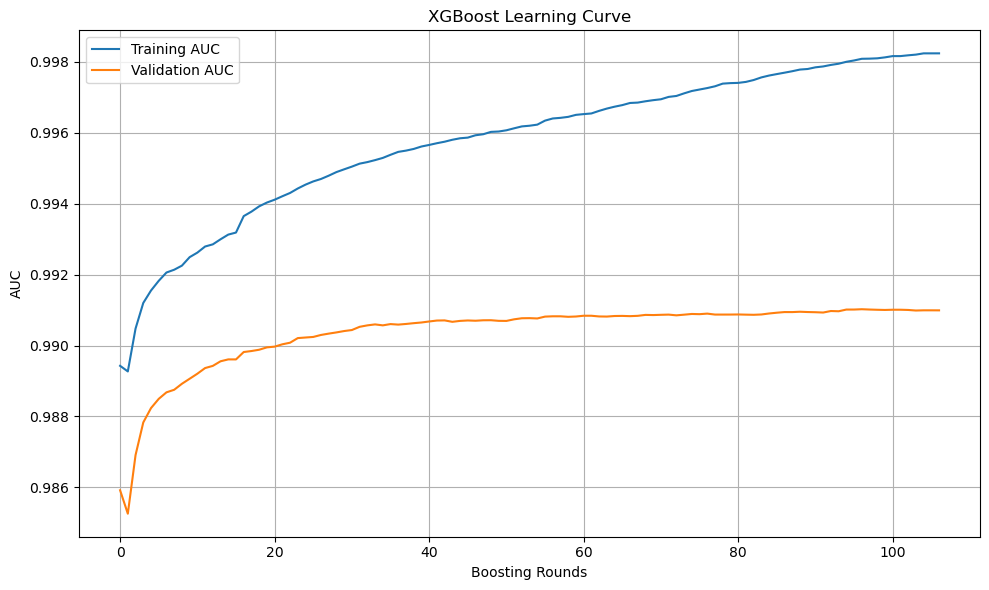

In [ ]:
# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(evals_result['train']['auc'], label='Training AUC')
plt.plot(evals_result['validation']['auc'], label='Validation AUC')
plt.title('XGBoost Learning Curve')
plt.xlabel('Boosting Rounds')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# === Step 4: Generate Prediction Results ===
# Make predictions on validation set
val_probs = final_model.predict(dval)
val_preds = [1 if prob > 0.5 else 0 for prob in val_probs]

# Create results dataframe similar to the LSTM version
# For XGBoost, we only have one probability output (for class 1)
results_df_xg = pd.DataFrame({
    "true_label": y_val,
    "predicted_label": val_preds,
    "probability_0": 1 - val_probs,  # Probability for class 0
    "probability_1": val_probs       # Probability for class 1
})

# Save and preview results
results_df_xg.to_csv("xgboost_results.csv")
results_df_xg

,true_label,predicted_label,probability_0,probability_1
0,0,0,0.940833,0.059167
1,0,0,0.995580,0.004420
2,0,0,0.997948,0.002052
3,0,0,0.991615,0.008385
4,0,0,0.996281,0.003719
...,...,...,...,...
34851,1,1,0.000096,0.999904
34852,0,0,0.998158,0.001842
34853,0,0,0.990775,0.009225
34854,0,0,0.947513,0.052488


## 4. Evaluate the Model

Using custom threshold of 0.3 for predictions

--- Evaluation on Training Data ---
AUC-ROC:     0.9982
F1-Score:    0.9627
Precision:   0.9615
Recall:      0.9640
Confusion Matrix:
[[115400    894]
 [   832  22297]]


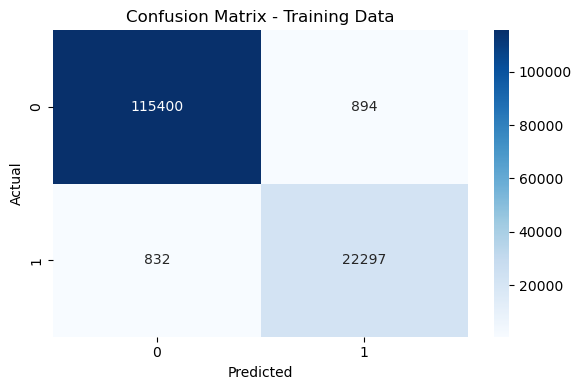

Using custom threshold of 0.3 for predictions

--- Evaluation on Validation Data ---
AUC-ROC:     0.9910
F1-Score:    0.9118
Precision:   0.9148
Recall:      0.9088
Confusion Matrix:
[[28589   489]
 [  527  5251]]


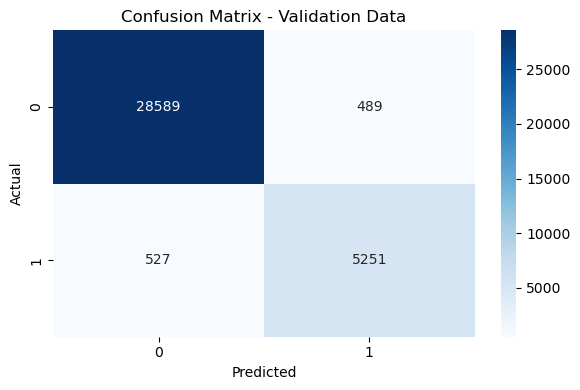

Using custom threshold of 0.3 for predictions

--- Evaluation on Test Data ---
AUC-ROC:     0.9663
F1-Score:    0.7738
Precision:   0.7049
Recall:      0.8577
Confusion Matrix:
[[112888   4373]
 [  1733  10444]]


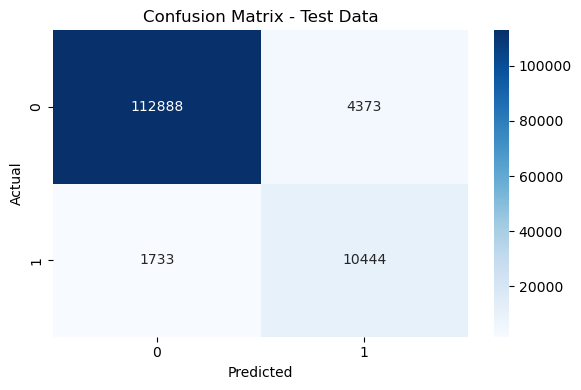

In [ ]:
# === Step 5: Evaluate Model ===
def evaluate_model(model, X, y, dataset_name="", threshold=0.5):
    dmatrix = xgb.DMatrix(X)
    y_prob = model.predict(dmatrix)
    
    # Use custom threshold as in the LSTM code (0.3)
    if threshold != 0.5:
        print(f"Using custom threshold of {threshold} for predictions")
    
    y_pred = [1 if prob > threshold else 0 for prob in y_prob]
    
    # Compute metrics
    auc = roc_auc_score(y, y_prob)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)
    
    # Print results
    print(f"\n--- Evaluation on {dataset_name} ---")
    print(f"AUC-ROC:     {auc:.4f}")
    print(f"F1-Score:    {f1:.4f}")
    print(f"Precision:   {precision:.4f}")
    print(f"Recall:      {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    
    return auc, f1, precision, recall

# Evaluate with the same threshold as LSTM (0.3) for fair comparison
threshold = 0.3

# Evaluate on all datasets
train_metrics = evaluate_model(final_model, X_train, y_train, "Training Data", threshold)
val_metrics = evaluate_model(final_model, X_val, y_val, "Validation Data", threshold)
test_metrics = evaluate_model(final_model, X_test, y_test, "Test Data", threshold)


<Figure size 1200x800 with 0 Axes>

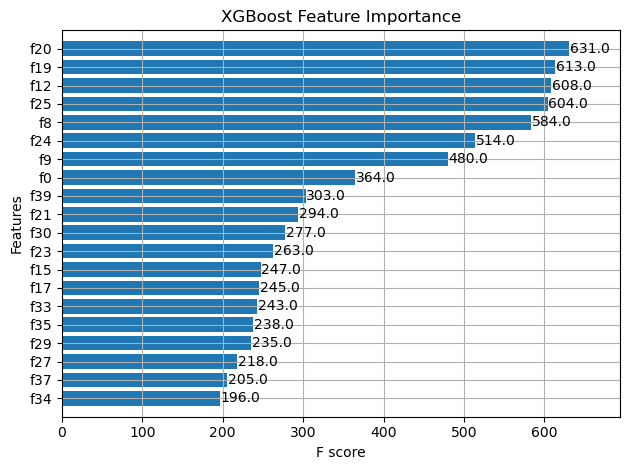


Top 10 Most Important Features:
  Feature   Importance
0     f11  5754.977051
1     f12   105.533546
2     f18    66.062073
3     f38    53.717640
4     f13    43.971928
5      f1    37.594028
6     f28    35.742203
7     f10    13.599256
8     f33     5.820590
9     f19     5.434865


In [ ]:
# === Step 6: Feature Importance Analysis ===
# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, max_num_features=20, height=0.8)
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Get feature names and importance values
feature_importance = final_model.get_score(importance_type='gain')

# Create a list of tuples with feature names and importance scores
feature_tuples = [(k, v) for k, v in feature_importance.items()]

# Sort by importance
sorted_features = sorted(feature_tuples, key=lambda x: x[1], reverse=True)

# Convert to dataframe for better display
importance_df = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])

# Print top 10 important features
print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

In [ ]:
# === Step 7: Results Comparison ===
print("\n=== Model Comparison Summary ===")
print(f"XGBoost Test AUC:     {test_metrics[0]:.4f}")
print(f"XGBoost Test F1:      {test_metrics[1]:.4f}")
print(f"XGBoost Test Recall:  {test_metrics[3]:.4f}")
print(f"XGBoost Test Precision: {test_metrics[2]:.4f}")


=== Model Comparison Summary ===
XGBoost Test AUC:     0.9663
XGBoost Test F1:      0.7738
XGBoost Test Recall:  0.8577
XGBoost Test Precision: 0.7049
